## Usefuls sources of informations:

* https://github.com/hbjornoy/deep-learning/blob/master/project2/helpers.py
* https://github.com/Ertugrulmert/EPFL-Deep-Learning-Projects/blob/master/Project_2/framework.py
* https://github.com/marieanselmet/DeepLearningEPFL_projects/tree/main/DL_framework_from_scratch

La grande différence est que tout le monde définit module avec un argument, et non une liste * -> à voir si on doit changer pour faire comme les années précédentes ou s'il y a qqc de plus pratique

## TODO

* Pour les modules retournant une empty list sur param, enlever la fonction param (ça sert à rien de l'override)

In [1]:
import torch
import math
import time
import datetime
import random

from torch import Tensor
torch.set_grad_enabled(False)

In [2]:
# The father of all Modules
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Activation

À part ReLU et Tanh c'est pas précisé dans l'énoncé - là c'est juste pour le flex

In [3]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.clamp(0)

    def backward(self, gradwrtoutput):
        input = self.t
        sign = input.sign().clamp(0)
        return sign * gradwrtoutput
        
    def param(self):
        return []

In [4]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        
        out = []
        for x in input :
            e = math.exp(-2 * x)
            val = (1 - e) / (1 + e)
            out.append(val)
        return torch.FloatTensor(out)

    def backward(self, gradwrtoutput):
        z = self.t
        e = torch.exp(-2 * z)
        d_tanh = 4 * e / (1 + e)**2
        return d_tanh * gradwrtoutput
        
    def param(self):
        return []

In [5]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.mul(-1).exp().add(1).pow(-1)

    def backward(self, gradwrtoutput):
        sig = self.t.mul(-1).exp().add(1).pow(-1)
        return sig.mul(-1).add(1).mul(sig)
        
    def param(self):
        return []

## Layers

In [6]:
class Linear(Module):
    def __init__(self, input_size, output_size, mean=0, std=1):
        super().__init__()
        self.W = torch.empty(output_size, input_size).normal_(mean, std)
        self.b = torch.empty(output_size).normal_(mean, std)
        self.dW = torch.zeros(output_size, input_size)
        self.db = torch.zeros(output_size)
    def forward(self, input):
        self.t = input
        return self.W.mv(input).add(self.b)

    def backward(self, gradwrtoutput):
        self.dW.add_(gradwrtoutput.view(1, -1).t().mm(self.t.view(1, -1)))
        self.db.add_(gradwrtoutput)
        #print(gradwrtoutput.shape, self.W.shape)
        return self.W.t().mv(gradwrtoutput)
        
        
    def param(self):
        return [(self.W, self.dW), (self.b, self.db)]

In [7]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        for i in range(input.shape[0]):
            if random.random() < self.p : 
                input[i] = 0 
        return input
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput
        
        
    def param(self):
        return []

In [8]:
l = Dropout(0.5)
t = torch.empty(10).fill_(1)
l.forward(t)

tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])

## Sequential

Lui en input il prend une liste de modules et son fwd c'est de feed le fwd de chaque layer dans l'autre

In [9]:
class Sequential(Module):
    def __init__(self, module_list):
        super().__init__()
        self.modules = module_list
        
    def forward(self, input):
        x = input
        for module in self.modules :
            x = module.forward(x)
        return x 

    def backward(self, gradwrtoutput):
        x = gradwrtoutput
        for module in reversed(self.modules) :
            x = module.backward(x)
        return x
        
    def param(self):
        params = []
        for module in self.modules:
            for par in module.param():
                params.append(par)
        return params

## Loss

Seule lossMSE est demandé

In [10]:
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).pow(2).mean()
    
    # J'ai pas mis les arguments dans backward car je pars du principe que la MSE est la dernière fonction utilisée
    def backward(self):
        return 2 * (self.pred - self.target)
    
    def param(self):
        return []

In [11]:
class LossMAE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).abs().mean()

    def backward(self):
        error = self.pred - self.target
        return error.sign()
        
    def param(self):
        return []

In [12]:
# Binary cross entropy loss
# Note: We need to use sigmoid function before using BCE otherwise it makes no sense
class LossBCE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return ((target * pred.log()) + ((1 - target) * (1 - pred).log())).mean()

    def backward(self):
        return ((-target/pred) + ((1 - target)/(1 - pred))).mean()
        
    def param(self):
        return []

## Optimizer

Pas demandé mais fancy

In [13]:
class SGD():
    def __init__(self, params, lr, seq = True):
        self.params = params
        self.lr = lr
        self.seq = seq
    def step(self): 
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                param.sub_(grad, alpha=self.lr)
    
    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        for idx, i in enumerate(self.params):
            print(idx, i)

In [14]:
class Adam():
    def __init__(self, params, lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.params = params
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # Adam inner values 
        self.t = 0
        self.adam_values = []
        for t in self.params:
            t0, t1 = t
            self.adam_values.append((torch.zeros_like(t0), torch.zeros_like(t1)))

    def step(self):
        self.t += 1 
        for idx_module, module in enumerate(self.params):
            param, grad = module
            if (param is not None) and (grad is not None):
                #Update Vd and Sd, for each tuple we keep vd and sd 
                vd, sd = self.adam_values[idx_module]

                vd.mul_(self.beta_1).add_(grad.mul(1 - self.beta_1))
                sd.mul_(self.beta_2).add_(grad.pow(2).mul(1 - self.beta_2))

                # Compute corrected Values
                vd_corr = vd.mul(torch.tensor([[self.beta_1]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                sd_corr = sd.mul(torch.tensor([[self.beta_2]]).pow(self.t).mul(-1).add(1).pow(-1)) 

                # Update the parameter 
                v =sd_corr.sqrt().add(self.epsilon).pow(-1).mul(vd_corr)
                
                param.sub_(v.reshape(param.shape), alpha=self.lr)

    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        print(self.t)
        print("PARAMS : ")
        for i in self.params:
            print(i)
        print(("ADAM [Vd, Sd] : "))
        for i in self.adam_values:
            print(i)

## Data generation

In [15]:
def generate_disc_dataset(nb, seed=0):
    torch.manual_seed(seed)
    input = torch.empty(nb, 2).uniform_(0, 1)
    
    distance = torch.norm((input - torch.Tensor([[0.5, 0.5]])), 2, 1, True)
    target = distance.mul(math.sqrt(2*math.pi)).sub(1).sign().sub(1).div(-2).long()  
    return input, target

In [16]:
# Pas sûr de l'interêt du one hot encoder vu l'énoncé mais je peux me tromper 
def one_hot_encoder(target):
    return torch.empty(target.size(0), 2).zero_().scatter_(1, target.view(-1, 1), 1)

In [17]:
def split_dataset(input, target, train_perc):
    train_part = math.floor(target.size()[0] * train_perc)
    test_part = target.size()[0] - train_part
    
    train_input = input.narrow(0, 0, train_part)
    test_input = input.narrow(0, train_part, test_part)
    
    train_target = target.narrow(0, 0, train_part)
    test_target = target.narrow(0, train_part, test_part)
    
    return train_input, train_target, test_input, test_target

In [18]:
def normalize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test

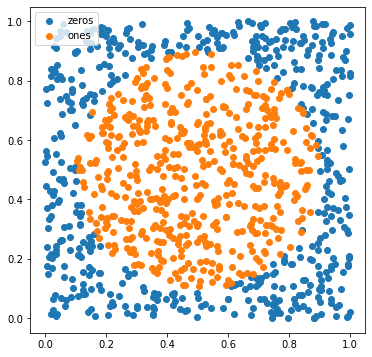

In [19]:
import matplotlib.pyplot as plt 

input, target = generate_disc_dataset(1000)

def plot_from_input(input, target):
    zeros = input[(target == 0).nonzero()[:,0]]
    ones = input[target.nonzero()[:,0]]
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.savefig('generated_data.png')
    plt.show()

plot_from_input(input, target)

## Train / Test

In [31]:
def train_SGD(model, train_input, train_target, learning_rate=0.0001, nb_epochs=500, print_ = False):
    print(f"Training the model on {nb_epochs} epochs with SGD optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    optimizer = SGD(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
            
        avg_acc_loss = acc_loss / train_input.shape[0]
        if print_ :
            print(f"epoch {epoch}, Loss {avg_acc_loss}")
    return model

def train_adam(model, train_input, train_target, learning_rate=0.05, nb_epochs=500, print_ = False):
    print(f"Training the model on {nb_epochs} epochs with Adam optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    optimizer = Adam(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
        avg_acc_loss = acc_loss / train_input.shape[0]
        if print_:
            print(f"epoch {epoch}, Loss {avg_acc_loss}")
    return model

In [21]:
# Compute the accuracy and plot the results 
def accuracy_and_plot(model, test_input, test_label):
    nb_correct = 0
    nb_total = test_input.shape[0]
    zeros = []
    ones = []
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        if prediction.argmax() == 0 :
            zeros.append(input)
        else :
            ones.append(input)
        
        nb_correct += prediction.argmax() == target
    zeros = torch.stack(zeros)
    ones = torch.stack(ones)
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.show()
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    print(f'Accuracy is : {accuracy}%')
    print(f'Error rate : {error_rate}%')
    
    return accuracy, error_rate

def accuracy(model, test_input, test_label, print_ = False):
    nb_correct = 0
    nb_total = test_input.shape[0]
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        
        nb_correct += prediction.argmax() == target
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    if print_ :
        print(f'Accuracy is : {accuracy}%')
        print(f'Error rate : {error_rate}%')
    
    return accuracy, error_rate


In [34]:
def train_and_plot_accuracy(model, train_input, train_target_one_hot, train_target, test_input, test_target, optim="sgd", learning_rate=0.0001, nb_epochs=500, print_=False):
    print(f"Training the model on {nb_epochs} epochs with {optim} optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    if optim == "adam":
        optimizer = Adam(model.param(), learning_rate)
    else :
        optimizer = SGD(model.param(), learning_rate)
    
    test_errs = []
    train_errs = []
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target_one_hot[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
        
        _, test_err = accuracy(model, test_input, test_target)
        _, train_err = accuracy(model, train_input, train_target)
        test_errs.append(test_err)
        train_errs.append(train_err)
        
        avg_acc_loss = acc_loss / train_input.shape[0]
        if print_:
            print(f"epoch {epoch}, Loss {avg_acc_loss}")
    plt.figure(figsize= (10,10))
    plt.plot(test_errs, label = "Test Error Rate")
    plt.plot(train_errs, label = "Train Error Rate")
    plt.legend()
    plt.savefig(f"Test_and_train_loss_{optim}_.png")
    plt.show()
    return model

## Data creation and code 

Note: j'ai pas compris si on doit utiliser 1000 datasets pour le train + 1000 dataset pour le test, pour le moment j'ai fait 1000 pour les 2 et je split ensuite, à voir comment on veut faire 

Note: Si on veut faire un truc fancy et visualiser notre data, il faudrait faire l'opération "inverse" du normalize data sur le dataset 

TODO: lr hypertuning w/ validation ? 

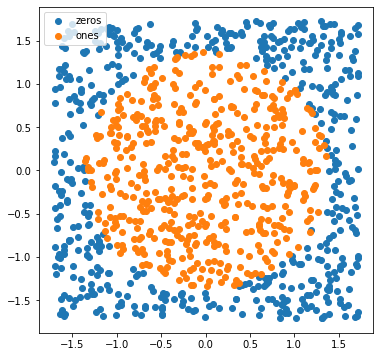

Training the model on 500 with SGD optimizer and learning rate 0.0001


In [23]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model_sgd = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model_sgd = train_SGD(model_sgd, train_input, one_hot_targets)

Performances using SGD optimizer
On train :


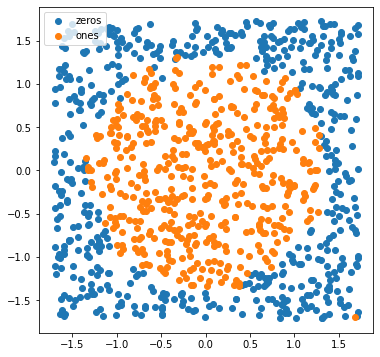

Accuracy is : 96.8%
Error rate : 3.200000000000003%
On test :


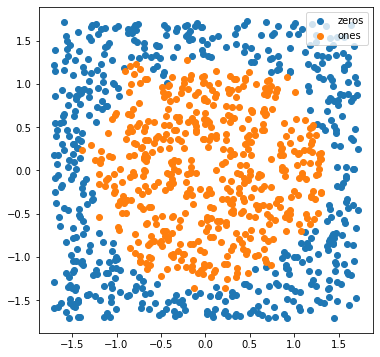

Accuracy is : 95.8%
Error rate : 4.200000000000003%


(95.8, 4.200000000000003)

In [27]:
print("Performances using SGD optimizer")
print("On train :")
accuracy_and_plot(model_sgd, train_input, train_target)
print("On test :")
accuracy_and_plot(model_sgd, test_input, test_target)

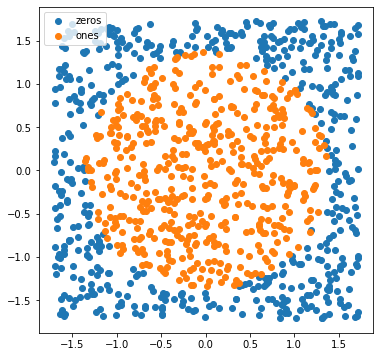

Training the model on 500 with Adam optimizer and learning rate 0.01


In [29]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model_adam = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model_adam = train_adam(model_adam, train_input, one_hot_targets, learning_rate=0.01, nb_epochs=500)

Performances using Adam optimizer
On train :


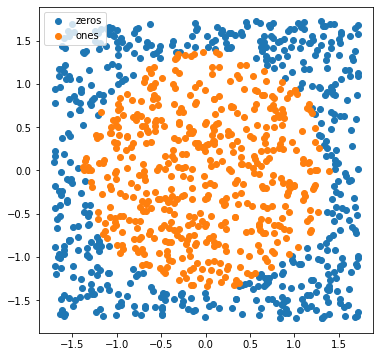

Accuracy is : 98.7%
Error rate : 1.2999999999999972%
On test :


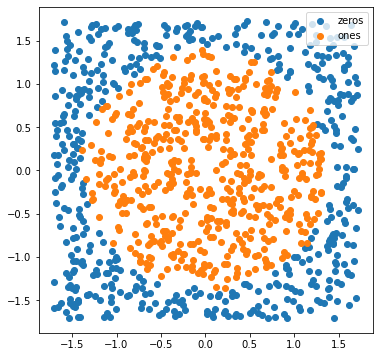

Accuracy is : 99.3%
Error rate : 0.7000000000000028%


(99.3, 0.7000000000000028)

In [30]:
print("Performances using Adam optimizer")
print("On train :")
accuracy_and_plot(model_adam, train_input, train_target)
print("On test :")
accuracy_and_plot(model_adam, test_input, test_target)

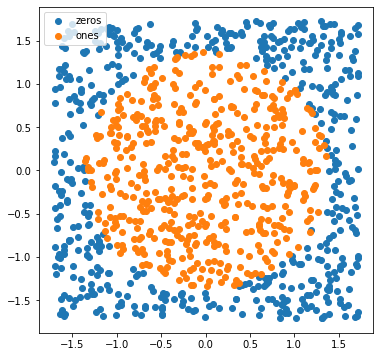

Training the model on 500 epochs with sgd optimizer and learning rate 0.0001


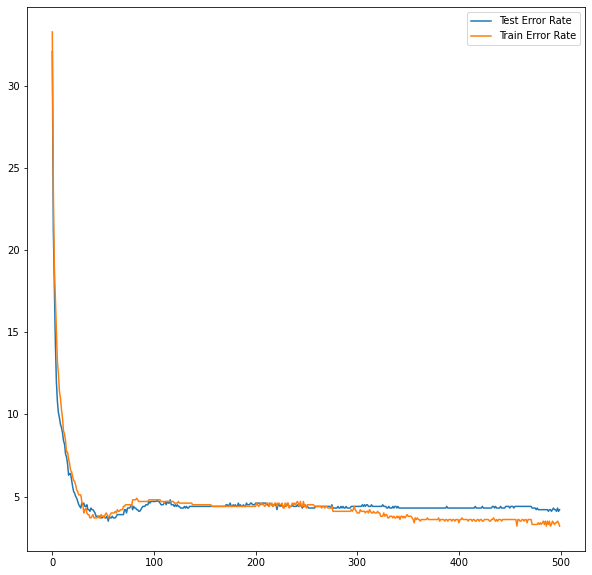

In [35]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

train_and_plot_accuracy(model, train_input, one_hot_targets, train_target, test_input, test_target)
    

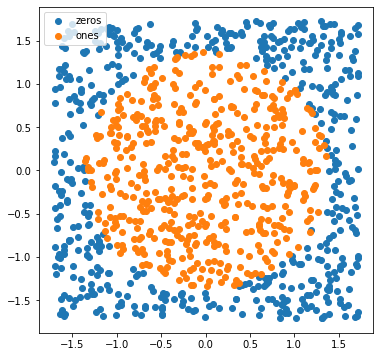

Training the model on 100 epochs with adam optimizer and learning rate 0.01


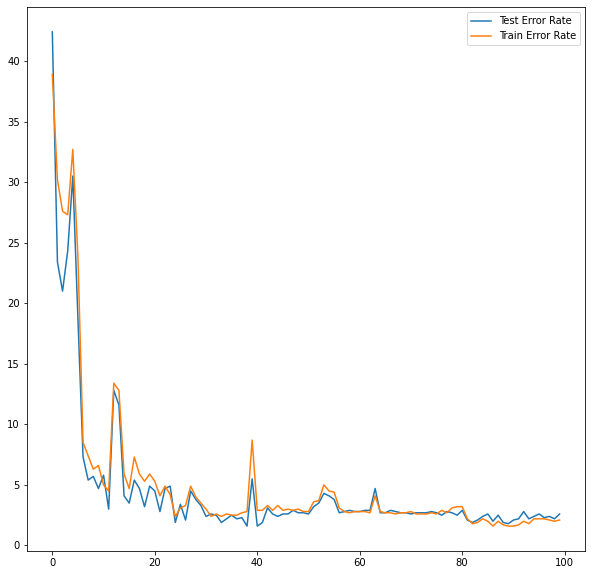

In [38]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

train_and_plot_accuracy(model, train_input, one_hot_targets, train_target, test_input, test_target, optim="adam", learning_rate=0.01, nb_epochs=100)
    